<h1>Analysis of FREYA</h1>
<h2>Correlated Fission Modeling</h2>
<hr>

<font size=4em >Ramona Vogt</font> <br />
(Lawrence Livermore National Laboratory and UC Davis) <br />
<a href="mailto:vogt2@lanl.gov">vogt2@llnl.gov</a>

<font size=3em >Jackson Van Dyke</font> <br />
(UC Berkeley) <br />
<a href="mailto:jacksonvandyke@lbl.gov">jacksonvandyke@lbl.gov</a>

## Test Package Requirements

In [1]:
#!/usr/bin/env python
from __future__ import print_function

class MissingLibrary:
    IMPORT_ERRORS = 0
    def import_error(library_name):
        print ("Could not import library: \"{0}\".".format(str(library_name)))
        print ("Install library by typing one of the following OS-dependent statements:")
        print (" sudo apt-get install {0} (on Ubuntu/Debian Linux systems)".format(str(library_name)))
        print (" sudo yum install {0} (on Fedora Linux systems)".format(str(library_name)))
        print (" sudo port install {0} (on Mac OS X systems, if MacPorts is installed)".format(str(library_name)))
        print (" sudo pip install {0} ".format(str(library_name)))
        print (" conda install {0} (if you have Anaconda)".format(str(library_name)))
        print (" conda install --name <my_environment> {0} (to install into a specified environment)".format(str(library_name)))
        print()
        MissingLibrary.IMPORT_ERRORS += 1

ML = MissingLibrary

try: import numpy
except: ML.import_error("numpy")
try: import matplotlib
except: ML.import_error("matplotlib")
try: import IPython
except: ML.import_error("IPython")

if ML.IMPORT_ERRORS == 0: print("All required Python libraries are installed")
else: 
    lib = None
    if ML.IMPORT_ERRORS == 1: lib = str("library")
    else: lib = str("libraries")
    print("You need to install {0} missing Python {1} to use this Notebook".format(ML.IMPORT_ERRORS, lib))


All required Python libraries are installed


# Introduction

The Fission Reaction Event Yield Algorithm (FREYA), which was developed at LBNL and LLNL, is a complete event model of fission. It is meant to quickly generate a large number of events suitable for incorporation into transport codes.  The idea was to make a physics-based model that can be used for both detector development and data comparison.  Samples of complete events, with full kinematic information on the energy and momentum of the fission products as well as emitted particles (effectively neutrons and photons), allow extraction of any observable of interest, including fluctuations and correlations, as well as taking into account cuts and acceptances. 

![title](data/header_photo.png)

How does FREYA work?

FREYA requires fission fragment yields as a function of mass, $A$, and charge, $Z$; $Y(A,Z)$, as well as the total kinetic energy of the fragments, TKE, as inputs.  Sampling from these inputs allows extraction of the excitation energy which is then divided between the two fragments, assuming binary fission.  The fragments are also assigned a rotational energy with the remainder of the fragment excitation energy given to intrinsic excitation for neutron emission.  The fragments are then de-excited by neutron emission, followed by photon emission which exhausts the rotational energy.  

FREYA assumes that neutron emission follows Weisskopf-Ewing spectrum with new temperature in the daughter nucleus formed every time a neutron is emitted.  Neutron emission proceeds until no more neutron emission is possible, then photons are emitted, first statistically with a Giant Dipole Resonance spectrum and then by specific transitions.

FREYA models both spontaneous and neutron induced fission up to incident neutron energies of 20 MeV.  To reach 20 MeV, we must include pre-equilibrium emission, where an incident neutron does not bind to form a compound nucleus but is ejected again instead, and multi-chance fission where one or more neutrons are emitted from the compound nucleus and enough energy is left afterwards for the compound to still fission.  Photofission is also possible although not as well modeled in the case of FREYA. 

References:

FREYA: J. Randrup and R. Vogt: Phys. Rev. C 80 (2009) 024601, 044611; 84 (2011) 044621; 85 (2012) 024608; 87 (2013) 044602; 89 (2014) 044601; 90 (2014) 064623; in progress; with J. Verbeke, Comp. Phys. Comm. 191 (2015) 178; FREYA2.0 submitted to CPC.

# Define Directories and File Formats

In [2]:
import os
cwd = os.getcwd()

DATADIR = cwd + "/data/"
WORKDIR = cwd + "/"
OUTPUTDIR = cwd + "/output/"

if not os.path.exists(OUTPUTDIR):
    os.makedirs(OUTPUTDIR)

FREYA_EVENTS_DEFAULT = DATADIR + "histories-Cf252sf-FREYA_default.dat"

EXP_DATA = DATADIR + "data-98252sf-sub.json" # Experimental data file

REACTIONLABEL = r"$^{252}$Cf (sf)"

NEVENTSREAD = 100000 # limit number of fission events read in to NEVENTSREAD

Ac = 252 # mass number of compound nucleus

### Python packages needed by the notebook

In [3]:
import sys
import time
import importlib as imp

import numpy as np
import pandas as pd
import math as math
import json

%load_ext Cython

import matplotlib.pyplot as plt
%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


### Import Python User Libraries 

In [4]:
import env            #-- set environment variables for plotting
import utils          #-- read and plot experimental data
import freya_utils    #-- FREYA utilities

# Reading experimental data sets

In [5]:
experiments = utils.readJSONDataFile (EXP_DATA)
utils.listExperimentalData (experiments)

YA              |  F.-J. Hambsch, S. Oberstedt, P. Siegler, J. van Arle, R. Vogt, 1997
YA              |  C. Budtz-Joergensen and H.-H. Knitter, 1988
YZ              |  Wahl, 1987
TKEA            |  Gook, 2014
Pnu             |  P. Santi and M. Miller, 2008
PFNS            |  W. Mannhart, 1989
PFNS2           |  W. Mannhart, 1989
nubarA          |  Vorobyev et al., 2004
EcmA            |  Budtz-Jorgensen and Knitter, 1988
nubarTKE        |  A. Gook, F.-J. Hambsch, M. Vidali, 2014
nLF             |  A. Skarsvag and K. Bergheim, 1963
nLF             |  H. R. Bowman, S. G. Thompson, J. C. D. Milton, and W. J. Swiatecki, 1962
nn              |  Pozzi et al., 2014
Pnug            |  A. Oberstedt, R. Billnert, F.-J. Hambsch, S. Oberstedt, et al., 2015


In [6]:
# Exercise: plot different experimental data sets (advice: check the file 'utils.py')
# >> Solution example: utils.plotExperimentalData(experiments,'YA',author="Hambsch")

## FREYA History File Format

The fission event generator FREYA records information about the events according to the format described below. The file containing the events starts with a single line,
$$
Z_{00},A_{00},E_{\text{input}},K 
$$

Here $Z_{00}$ and $A_{00}$ are the charge and mass numbers of the original compound nucleus, prior to any prefission emissions. Furthermore, $E_{\text{input}}$ is the energy value entered (if $E_{\text{input}} > 0$ it denotes the kinetic energy of the incoming neutron, if $E_{\text{input}} < 0$ its absolute value denotes the
initial excitation energy, and if $E_{\text{input}} = 0$ the case considered is spontaneous fission). Finally, K is the total number of fission events recorded. (A line shift is denoted by ’//’.)

In the description below, $p$ denotes the momentum of a neutron, its kinetic energy is given by $E = p^2/2m_n$, and $\hat p = p/|p|$ is a unit vector in its direction of motion; furthermore, $q$ denotes the momentum of a photon, its kinetic energy is given by $\epsilon = |q|$, and $\hat q = q/|q|$ is a unit vector in its direction of motion. 

For each event $k$ of the $K$ fission events, the following information is recorded:

First information prior to fission (including any pre-fission emission), is recorded:

$k,Z_0,A_0,E_0^*, N_n^{(0)}, N_{\gamma}^{(0)}$

$E_0^{\text{kin}} , \hat P_0$

$(E_n^{(0)} , \hat p_n^{(0)}), n = 1, . . . ,N_n^{(0)}$

Here $N^{(0)}_n$ and $N^{(0)}_{\gamma}$ are the number of pre-fission neutrons and photons emitted (up to now, the latter always vanishes but it is included with a view towards future extensions of FREYA), and $Z_0$ and $A_0$ are the charge and mass numbers of the nucleus that actually fissions (so $Z_0 = Z_{00}$
and $A_0 = A_{00}−N_n^{(0)}$), and $E_0^*$ is its excitation energy. $E_0^{kin}$ is the kinetic energy of the fissioning nucleus, and 
$\hat P_0 = P_0 / |P_0|$
is the unit vector pointing in its direction of motion. Then follows the kinematic information on the pre-fission neutrons, if there are any.


Then the information associated with the light fission fragment is recorded, 

$k,Z_1,A_1,E_1^*, N_n^{(1)}, N_{\gamma}^{(1)}$

$E_1^{\text{kin}} , \hat P_1$

$(E_n^{(1)} , \hat p_n^{(1)}), n = 1, . . . ,N_n^{(1)}$

$(\epsilon_n^{(1)} , \hat q_n^{(1)}), n = 1, . . . ,N_n^{(1)}$

Here $Z_1$ and $A_1$ are the charge and mass numbers of the light primary fission fragment and $E_1^*$ is its excitation energy (before any emission); $N_n^{(1)}$ and $N_{\gamma}^{(1)}$ are the number of neutrons and photons emitted; $E_1^{kin}$ is the kinetic energy of the resulting product nucleus and $\hat P_1 = P_1/|P_1|$ is a unit vector in its direction of motion. Then follow the kinematic information on the individual neutrons (if any) and photons (if any).

Finally, the similar information associated with the heavy fission fragment is recorded,

$k,Z_2,A_2,E_2^*, N_n^{(2)}, N_{\gamma}^{(2)}$

$E_2^{\text{kin}} , \hat P_2$

$(E_n^{(2)} , \hat p_n^{(2)}), n = 1, . . . ,N_n^{(2)}$

$(\epsilon_n^{(2)} , \hat q_n^{(2)}), n = 1, . . . ,N_n^{(2)}$

Here $Z_2$ and $A_2$ are the charge and mass numbers of the heavy primary fission fragment and $E_2^*$ is its excitation energy (before any emission); $N_n^{(2)}$ and $N_{\gamma}^{(2)}$ are the number of neutrons and photons emitted; $S_2^{kin}$ is the kinetic energy of the product nucleus and $\hat P_2 = P_2/|P_2|$ is a
unit vector in its direction of motion. Then follows the kinematic information on the individual neutrons (if any) and photons (if any).

After all the $K$ events have been recorded, a single line with ’0 0 0’ in format is written, signifying that the recording is complete; although this is in principle redundant, it is very convenient.

As already pointed out above, the mass number of the fissioning nucleus is equal to the mass number of the original compound nucleus minus the number of pre-fission neutrons. Likewise, the mass number of a product nucleus is equal to the mass number of the primary fragment precursor minus the number of neutrons it has evaporated. Furthermore, the momentum of the initial compound nucleus is equal to the momentum of the fissioning nucleus plus the momenta of any pre-fission neutrons. Likewise, the momentum of a product nucleus plus the momenta of all the associated ejectiles add up to the momentum of the precursor fragment, and the two fragment momenta in turn add up to the momentum of the fissioning nucleus.

# Reading Output History Files

## Reading FREYA Events

In [8]:
default_events, default_initial_line = freya_utils.freya_read(FREYA_EVENTS_DEFAULT)

Importing Events...
1000000 events imported.
Time: 21.301079034805298 sec


In [9]:
print (default_events[0])

['1   98  252     0.000    0    0', '0.000 -0.000  0.000  0.000', '1   36   95     2.880    0    4', '110.083 -0.711  0.474  0.519', '1.933 -0.252  0.587  0.769   0.427  0.165 -0.974 -0.152   0.227  0.857  0.214  0.468   0.154 -0.115 -0.991 -0.063', '1   62  157    18.998    2    8', '66.381  0.714 -0.476 -0.514', '0.390 -0.598  0.755  0.268   2.292  0.472 -0.481 -0.739', '1.434 -0.590 -0.457 -0.665   0.611  0.169 -0.034 -0.985   0.364  0.391  0.114 -0.913   0.256  0.169  0.406 -0.898   0.387  0.409  0.621 -0.668   0.494  0.719 -0.533 -0.446   0.418  0.435  0.674  0.597   0.177 -0.764 -0.086  0.640']


# Reconstruct Arrays of Observables

## FREYA Arrays

Note they have as many rows as we have bins
 and 3 columns (bins, values, variance)

In [10]:
freya_output, ranges_x = freya_utils.freya_parse(default_events, NEVENTSREAD, default_initial_line, 3)

Parsing events...
Time: 0.003376007080078125 sec
All events parsed.
Time: 12.812971830368042 sec


# Results and Comparison

Here we compare results from FREYA, first on the initial inputs:  fragment yields as a function of $A$ and $Z$, the average values of energies and multiplicities; and the total kinetic energies.

The average values of fragment mass $A$; charge $Z$; total excitation energy TXE; total kinetic energy TKE; average neutron multiplicity, $\langle \nu \rangle$, and neutron energy in the laboratory frame $\langle E_n^{\rm lab} \rangle$; and average photon multiplicity, $\langle \nu_\gamma \rangle$, and photon energy in the laboratory frame $\langle E_n^{\rm lab} \rangle$ are tabulated for the two codes for the light and heavy fragments individually as well as the weighted average of the two. 

The fission fragment yields compare FREYA results both pre- and post-neutron emission respectively in different plots.  The pre-neutron emission results are compared to 2014 data from Gook et al.

The charge yields from both codes are compared to each other and to the Wahl data.

Next the results on total kinetic energy are compared.  We will look at the kinetic energy probability distribution for the two fragments individually and to the total.  The results on the total kinetic energy and the width of the total kinetic energy distribution as a function of heavy fragment mass from the codes are compared to the Gook data.  FREYA adjusts the average TKE to match the average total neutron multiplicity, $\overline \nu$. In addition,  FREYA generates $\sigma_{\rm TKE}$ from thermal fluctuations (related to the shape of the neutron multiplicity distribution, as discussed later).

The FREYA probability distribution as a function of total excitation energy, both for the individual fragments and the total, are then shown.

Finally an intensity plot of the kinetic energy of the two fragments as a function of $A$ is compared for the two codes.  The intensities are highest for the most probable masses and kinetic energies, allowing one to see the spread in KE and $A$.

In [11]:
table = utils.ListTable()

table.append(['<b><font size="3.5">FREYA','<b>All Fragments','<b>Light Fragments','<b>Heavy Fragments'])
table.append(['A',"{0:5.2f}".format(mean(freya_output["Al"]+freya_output["Ah"])),"{0:5.2f}".format(mean(freya_output["Al"])),"{0:5.2f}".format(mean(freya_output["Ah"]))])
table.append(['Z',"{0:5.2f}".format(mean([freya_output['Z_l'],freya_output['Z_h']])),"{0:5.2f}".format(mean(freya_output['Z_l'])),"{0:5.2f}".format(mean(freya_output['Z_h']))])
table.append(['TXE / U (MeV)',"{0:5.2f}".format(mean(freya_output["TXE"])),"{0:5.2f}".format(mean(freya_output["Ul"])),"{0:5.2f}".format(mean(freya_output["Uh"]))])
table.append(['TKE / KE (MeV)',"{0:5.2f}".format(mean(np.nan_to_num(freya_output["TKE"]))),"{0:5.2f}".format(mean(np.nan_to_num(freya_output["KEl"]))),"{0:5.2f}".format(mean(np.nan_to_num(freya_output["KEh"])))])
table.append([r'$\langle \nu\rangle$',"{0:5.2f}".format(mean(freya_output['light_neutrons'])+mean(freya_output['heavy_neutrons'])),"{0:5.2f}".format(mean(freya_output['light_neutrons'])),"{0:5.2f}".format(mean(freya_output['heavy_neutrons']))])
table.append([r'$\langle E_n^{\rm lab}\rangle$ (MeV)',"{0:5.2f}".format(mean(freya_output['n_spec'])),"{0:5.2f}".format(mean(freya_output['light_n_spec'])),"{0:5.2f}".format(mean(freya_output['heavy_n_spec']))])
table.append([r'$\langle \nu_\gamma\rangle$',"{0:5.2f}".format(mean(freya_output['light_gammas']) + mean(freya_output['heavy_gammas'])),"{0:5.2f}".format(mean(freya_output['light_gammas'])),"{0:5.2f}".format(mean(freya_output['heavy_gammas']))])
table.append([r'$\langle E_\gamma^{\rm lab}\rangle$ (MeV)',"{0:5.2f}".format(mean(freya_output['m_spec'])),"{0:5.2f}".format(mean(freya_output['light_m_spec'])),"{0:5.2f}".format(mean(freya_output['heavy_m_spec']))])
table


FREYA,All Fragments,Light Fragments,Heavy Fragments
A,126.00,108.46,143.54
Z,49.00,42.18,55.82
TXE / U (MeV),32.78,19.37,13.40
TKE / KE (MeV),181.39,102.76,78.63
$\langle \nu\rangle$,3.71,2.17,1.54
$\langle E_n^{\rm lab}\rangle$ (MeV),2.30,2.65,1.81
$\langle \nu_\gamma\rangle$,7.75,4.01,3.74
$\langle E_\gamma^{\rm lab}\rangle$ (MeV),0.90,0.89,0.91


# Fission Fragment Yields

### Mass Yields

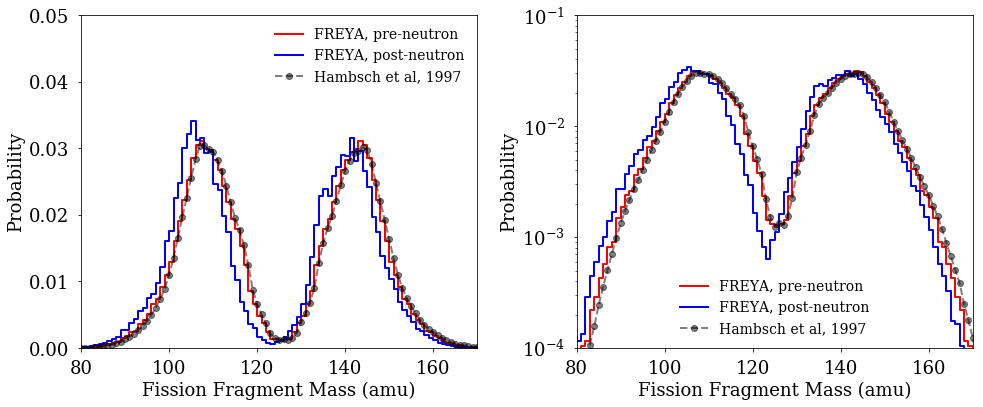

In [12]:
fig = figure(figsize(14,6))

#-- lin-scale
ax = plt.subplot(1,2,1,xlabel="Fission Fragment Mass (amu)",ylabel="Probability") 
plt.step(freya_output['Fragment_A'][:,0],freya_output['Fragment_A'][:,1],'r-',label="FREYA, pre-neutron")
plt.step(freya_output['Product_A'][:,0],freya_output['Product_A'][:,1],'b--',label="FREYA, post-neutron")
utils.plotExperimentalData(experiments,'YA',author='Hambsch')    
plt.xlim(80,170)
plt.ylim(0.0,0.05)
lg = plt.legend(fontsize=14,numpoints=1)
lg.draw_frame(False)

#-- log-scale
plt.subplot(1,2,2,xlabel="Fission Fragment Mass (amu)",ylabel="Probability",sharex=ax) 
plt.step(freya_output['Fragment_A'][:,0],freya_output['Fragment_A'][:,1],'r-',label="FREYA, pre-neutron")
plt.step(freya_output['Product_A'][:,0],freya_output['Product_A'][:,1],'b--',label="FREYA, post-neutron")
utils.plotExperimentalData(experiments,'YA',author='Hambsch')
plt.yscale('log')
plt.xlim(80,170)
plt.ylim(0.0001,0.1)
lg = plt.legend(fontsize=14,numpoints=1)
lg.draw_frame(False)

plt.tight_layout()
plt.show()
fig.savefig(OUTPUTDIR+"freya_YA.pdf")

### Charge Yields

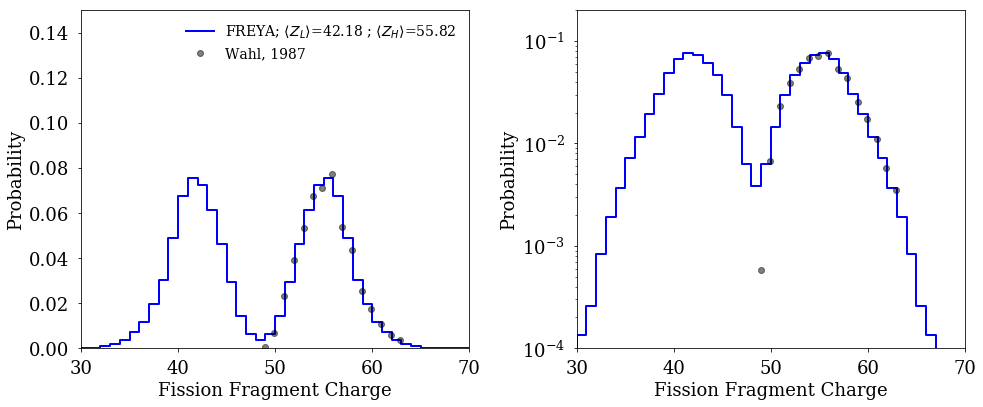

In [13]:
### EXERCISE: plot the charge yields

### SOLUTION BELOW ---

fig = figure(figsize(14,6))

#-- lin-scale
ax = plt.subplot(1,2,1,xlabel="Fission Fragment Charge",ylabel="Probability")
plt.step(freya_output['Z'][:,0],freya_output['Z'][:,1],'b--',label="FREYA; " + r"$\langle Z_L \rangle$={0:.2f} ; $\langle Z_H \rangle$={1:.2f}".format(np.average(freya_output['Z_l']),np.average(freya_output['Z_h'])))
utils.plotExperimentalData (experiments,'YZ',format="ko")
plt.xlim(30,70)
plt.ylim(0.0,0.15)
lg = plt.legend(fontsize=14,numpoints=1)
lg.draw_frame(False)

#-- log-scale
plt.subplot(1,2,2,xlabel="Fission Fragment Charge",ylabel="Probability",sharex=ax)
plt.step(freya_output['Z'][:,0],freya_output['Z'][:,1],'b--',label="FREYA; " + r"$\langle Z_L \rangle$={0:.2f} ; $\langle Z_H \rangle$={1:.2f}".format(np.average(freya_output['Z_l']),np.average(freya_output['Z_h'])))
utils.plotExperimentalData (experiments,'YZ',format='ko')
plt.xlim(30,70)
plt.ylim(0.0001,0.2)
plt.yscale('log')

plt.tight_layout()
plt.show()
fig.savefig(OUTPUTDIR+"YZ.pdf")


### Kinetic Energy

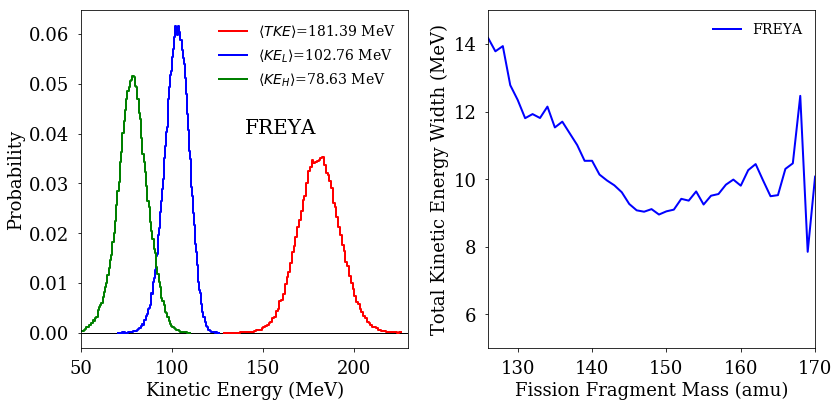

In [14]:
### EXERCISE: plot kinetic energy distribution

fig = figure(figsize(12,6))

#-- Y(KE_light), Y(KE_heavy), Y(TKE)
plt.subplot(1,2,1,xlabel="Kinetic Energy (MeV)",ylabel="Probability")

#-- TKE
h, binEdges = np.histogram(freya_output["TKE"],bins=100,normed=True)
binCenters = 0.5*(binEdges[1:]+binEdges[:-1])
plt.step(binCenters,h,'r-',label=r"$\langle TKE \rangle$={0:.2f} MeV".format(mean(freya_output["TKE"])))

#-- TKE light fragment
h, binEdges = np.histogram(freya_output["KEl"],bins=100,normed=True)
binCenters = 0.5*(binEdges[1:]+binEdges[:-1])
plt.step(binCenters,h,'b-',label=r"$\langle KE_L \rangle$={0:.2f} MeV".format(mean(freya_output["KEl"])))

#-- TKE heavy fragment
h, binEdges = np.histogram(freya_output["KEh"],bins=100,normed=True)
binCenters = 0.5*(binEdges[1:]+binEdges[:-1])
plt.step(binCenters,h,'g-',label=r"$\langle KE_H \rangle$={0:.2f} MeV".format(mean(freya_output["KEh"])))

#plt.ylim(0.0,0.2)
plt.xlim(50,230)
lg = plt.legend(fontsize=14)
lg.draw_frame(False)
plt.axhline(y=0,xmin=0,xmax=3,c="black",linewidth=1,zorder=0)
plt.text(140,0.04,'FREYA',fontsize=20)

plt.subplot(1,2,2)

plt.plot(freya_output['TKE_A'][:,0],freya_output['TKE_A'][:,2],'b-',label="FREYA")

lg = plt.legend(fontsize=14,numpoints=1)
lg.draw_frame(False)
plt.xlim(126,170)
plt.ylim(5,15)
plt.xlabel("Fission Fragment Mass (amu)")
plt.ylabel("Total Kinetic Energy Width (MeV)")
lg = plt.legend(fontsize=14,numpoints=1)
lg.draw_frame(False)

plt.tight_layout()

plt.show()

fig.savefig(OUTPUTDIR+"YKE.pdf")


### Initial Excitation Energy

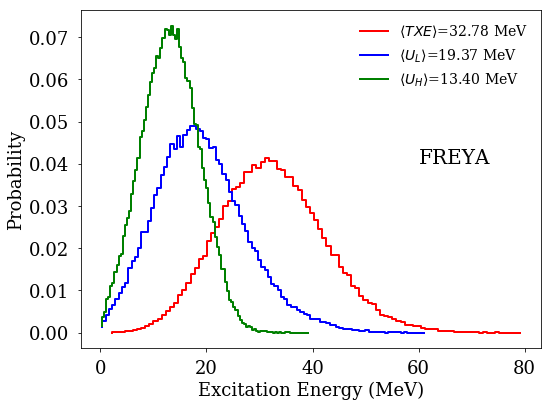

In [18]:
# Plots

fig = figure(figsize(8,6))

binwidth=1.0

#-- TXE
h, binEdges = np.histogram(freya_output["TXE"],bins=100,normed=True)
binCenters = 0.5*(binEdges[1:]+binEdges[:-1])
plt.step(binCenters,h,'r-',label=r"$\langle TXE \rangle$={0:.2f} MeV".format(mean(freya_output['TXE'])))

#-- Excitation energy light fragment
h, binEdges = np.histogram(freya_output["Ul"],bins=100,normed=True)
binCenters = 0.5*(binEdges[1:]+binEdges[:-1])
plt.step(binCenters,h,'b--',label=r"$\langle U_L \rangle$={0:.2f} MeV".format(mean(freya_output['Ul'])))

#-- Excitation energy heavy fragment
h, binEdges = np.histogram(freya_output["Uh"],bins=100,normed=True)
binCenters = 0.5*(binEdges[1:]+binEdges[:-1])
plt.step(binCenters,h,'g--',label=r"$\langle U_H \rangle$={0:.2f} MeV".format(mean(freya_output['Uh'])))

plt.xlabel("Excitation Energy (MeV)")
plt.ylabel("Probability")
lg = plt.legend(fontsize=14,numpoints=1)
lg.draw_frame(False)
plt.text(60,0.04,'FREYA',fontsize=20)

plt.tight_layout()

plt.show()

fig.savefig(OUTPUTDIR+"TXE.pdf")

### Yields (A,KE)

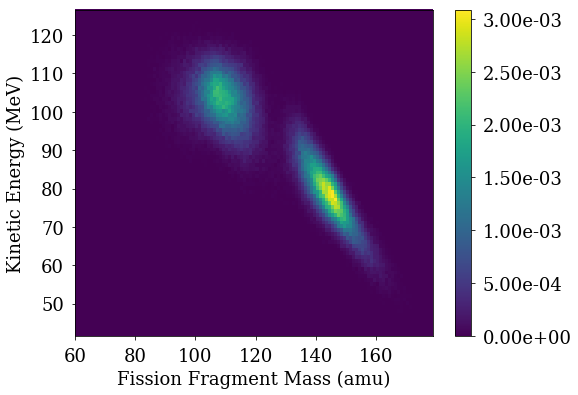

In [19]:
fig=figure(figsize(8,6))

bx=range(ranges_x['A'][0],ranges_x['A'][1],1)
by=np.arange(np.nanmin(freya_output["KE_A"][:,1]),np.nanmax(freya_output["KE_A"][:,1])+1.0,1.0)
plt.hist2d(np.nan_to_num(freya_output["KE_A"])[:,0],
           np.nan_to_num(freya_output["KE_A"])[:,1], 
           bins = (bx,by), normed  = True)

plt.colorbar(format='%7.2e')
#plt.title("FREYA")

plt.xlabel("Fission Fragment Mass (amu)")
plt.ylabel("Kinetic Energy (MeV)")

plt.show()

fig.savefig(OUTPUTDIR+"yields2D.pdf")


### Correlation (TKE,TXE)

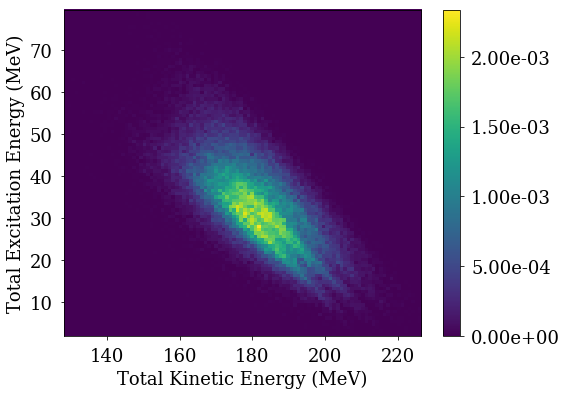

In [20]:
fig=figure(figsize(8,6))

plt.hist2d(np.nan_to_num(freya_output["TKE"]),
          np.nan_to_num(freya_output["TXE"]),bins=(100,100),normed=True)

plt.colorbar(format='%7.2e')

plt.xlabel("Total Kinetic Energy (MeV)")
plt.ylabel("Total Excitation Energy (MeV)")

plt.show()

fig.savefig(OUTPUTDIR+"corrTKE-TXE.pdf")

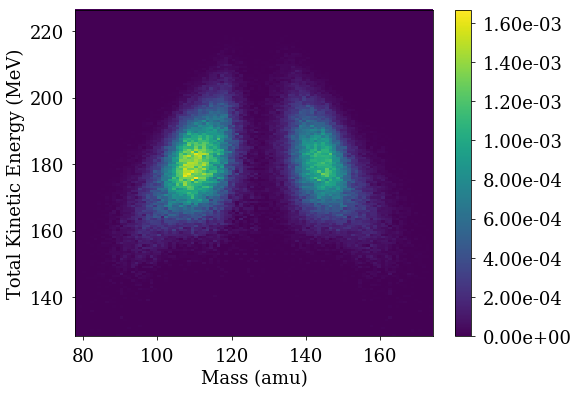

In [21]:
fig=figure(figsize(8,6))

nu = np.concatenate((freya_output["light_neutrons"],freya_output["heavy_neutrons"]))
A = np.concatenate((freya_output['Al'],freya_output['Ah']))
TKE = np.tile(freya_output['TKE'],2)

plt.hist2d(A, TKE,bins=(max(A) - min(A),150),weights=nu, normed = True)

plt.colorbar(format='%7.2e')

plt.xlabel("Mass (amu)")
plt.ylabel("Total Kinetic Energy (MeV)")

plt.show()

fig.savefig(OUTPUTDIR+"nu_A_TKE.pdf")

## Prompt  Fission Neutrons

Here the FREYA results are compared for neutron emission.  The results are also compared with data where possible.

First results for the neutron multiplicity distribution are shown, both on a linear and a log scale.  The calculations are compared to the 2008 evaluation by Santi and Miller.  We point out that the neutron multiplicity distribution is not Poisson-like because, in addition to the neutron kinetic energy released with each neutron emitted, the fragment energy also changes by the neutron separation energy.

Next the prompt fission neutron spectra are compared to the Mannhart evaluation.  To emphasize different parts of the spectra, the results are shown on log-linear, linear-linear and linear-log scales.  The ratio of the two calculations to a Mexwellian shape with a temperature of 1.32 MeV is also shown on a linear-log scale.

The neutron multiplicity as a function of fragment mass and total kinetic energy are also shown.

Lastly, the neutron-neutron angular correlation is shown as a function of angle between the two neutrons.  The neutrons are emitted isotropically in the rest frame of the fragment but, boosted to the lab frame, the neutrons follow the fragment.  Thus if the two neutrons detected each come from different fragments, they are 180 degrees apart, while if they come from the same fragment, their separation is 0 degrees.

### Prompt Fission Neutron Multiplicity Distribution $P(\nu)$

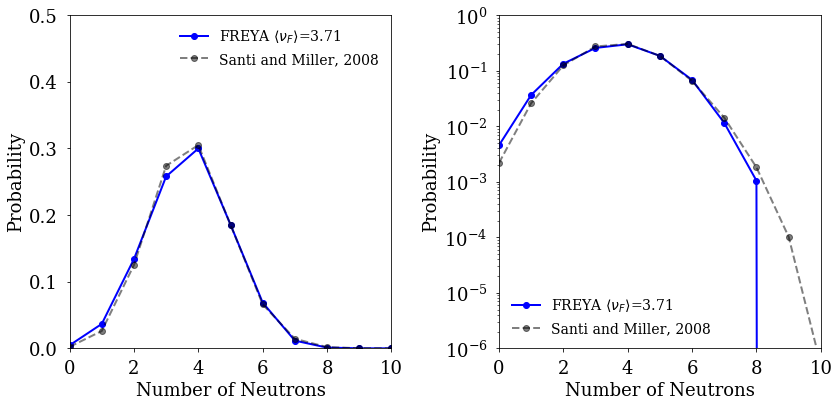

In [22]:
fig = figure(figsize(12,6))

#-- y-scale: linear
plt.subplot(1,2,1)
plt.plot(freya_output['n_mult'][:,0],freya_output['n_mult'][:,1],'bo-',label=r"FREYA $\langle \nu_F \rangle$={0:.2f}".format(10*freya_output['nubar']))
utils.plotExperimentalData (experiments,'Pnu')
plt.xlim(0,10)
plt.ylim(0.0,0.5)
plt.xlabel("Number of Neutrons")
plt.ylabel("Probability")
lg = plt.legend(numpoints=1,fontsize=14)
lg.draw_frame(False)

#-- y-scale: log
plt.subplot(1,2,2)
plt.plot(freya_output['n_mult'][:,0],freya_output['n_mult'][:,1],'bo-',label=r"FREYA $\langle \nu_F \rangle$={0:.2f}".format(10*freya_output['nubar']))
utils.plotExperimentalData (experiments,'Pnu')
plt.xlim(0,10)
plt.ylim(1e-6,1)
plt.xlabel("Number of Neutrons")
plt.ylabel("Probability")
plt.yscale('log')
lg = plt.legend(loc=3,numpoints=1,fontsize=14)
lg.draw_frame(False)


plt.tight_layout()
plt.show()
fig.savefig(OUTPUTDIR+"Pnu.pdf")


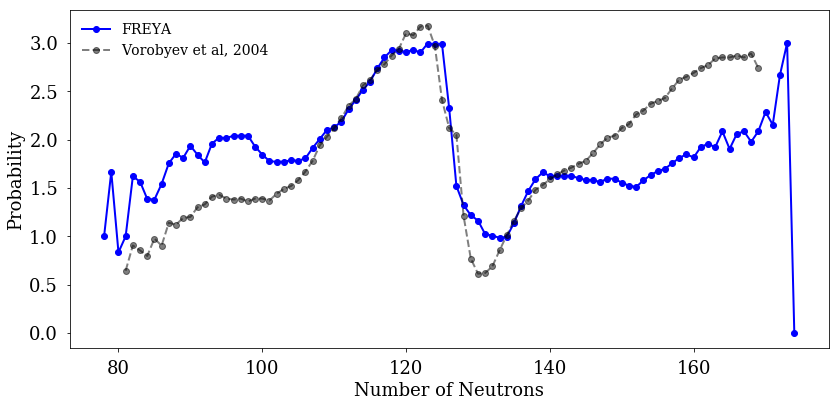

In [23]:
fig = figure(figsize(12,6))

#-- y-scale: linear

plt.plot(freya_output['n_Af'][:,0],freya_output['n_Af'][:,1],'bo-',label="FREYA")
utils.plotExperimentalData (experiments,'nubarA')
# plt.xlim(0,10)
# plt.ylim(0.0,0.5)
plt.xlabel("Number of Neutrons")
plt.ylabel("Probability")
lg = plt.legend(numpoints=1,fontsize=14)
lg.draw_frame(False)


plt.tight_layout()
plt.show()
fig.savefig(OUTPUTDIR+"n_Af.pdf")


### Prompt Fission Neutron Spectrum

In [24]:
# Outgoing energy grid
egrid = np.logspace(-3,2,100)
degrid = egrid[1:]-egrid[:-1]

#### Definition of Maxwellian and Watt spectra

We now attempt to model the prompt fission neutron spectrum. We will use a Maxwellian and Watt spectrum. 
The Maxwellian is an exponential distribution given by the following:
$$
M(E,T) = 
2\left(\frac{1}{T}\right)^{3/2}
\sqrt{\frac{E}{\pi}}
e^{-E/T}
$$
The temperature $T$ can be varied to obtain the proper fit.
The Watt spectrum is also defined to be a simple analytic expression:
$$
W(a,b,x) = 
I^{-1} e^{-x/a} \sinh\left(
\sqrt{bx}\right)
$$
where $I$ is a not-so-simple normalization constant. 
The coefficients $a,b$ vary from isotope to isotope.

In [25]:
from math import exp, sinh, sqrt, erf

def Maxwellian(e,T):
    return sqrt(e)*exp(-e/T)*(2/sqrt(np.pi)/sqrt(T)/T)

def Watt (a,b,x):
    W = 0.7*exp(-x/a)*sinh(sqrt(b*x))
    U = -30.0
    I = 0.5*sqrt(pi*a**3*b/4)*exp(a*b/4)*( erf(sqrt((x-U)/a)-sqrt(a*b/4)) +
                                          erf(sqrt((x-U)/a)+sqrt(a*b/4)) ) - a*exp(-(x-U)/a)*sinh(sqrt(b*(x-U)))
    return 1.5*W/I

vMaxwellian = np.vectorize(Maxwellian)
vWatt = np.vectorize(Watt)

def WattSpectrum (a,b):
    egrid = np.logspace(-3,2,100)
    return vWatt(a,b,egrid)

def MaxwellianSpectrum(T):
    egrid = np.logspace(-3,2,100)
    return vMaxwellian(egrid,T)

In [26]:
# Mannhart as a Watt spectrum:
yWatt = WattSpectrum(1.209,0.836)

In [27]:
hlab_freya , binEdges_freya = np.histogram(freya_output['n_spec'],bins = egrid)
binCenters_freya = 0.5 * (binEdges_freya[1:] + binEdges_freya[:-1])

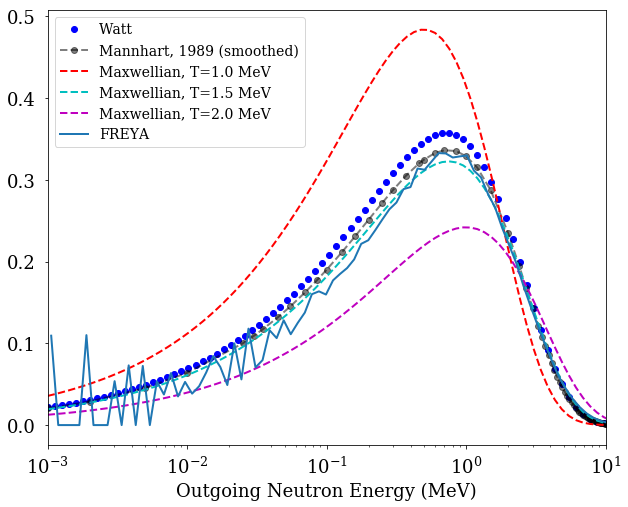

In [28]:
# EXERCISE: play with the temperature of the Maxwellian, and try to fit the Watt spectrum with a Maxwellian
T=(1.0,1.5,2.0)

fig=figure(figsize(10,8))

n = np.sum(freya_output['neutrons'])

plt.plot(egrid,yWatt,'bo',label="Watt")
utils.plotExperimentalData(experiments,'PFNS')
plt.plot(egrid,MaxwellianSpectrum(T[0]),'r--',label="Maxwellian, T={0} MeV".format(T[0]))
plt.plot(egrid,MaxwellianSpectrum(T[1]),'c--',label="Maxwellian, T={0} MeV".format(T[1]))
plt.plot(egrid,MaxwellianSpectrum(T[2]),'m--',label="Maxwellian, T={0} MeV".format(T[2]))
plt.plot(binCenters_freya, hlab_freya/degrid/n, label = "FREYA")
plt.xlim(0.001,10.0)
plt.xscale('log')
plt.xlabel("Outgoing Neutron Energy (MeV)")
plt.legend(fontsize=14)
plt.show()

### Neutron Multiplicity vs. TKE

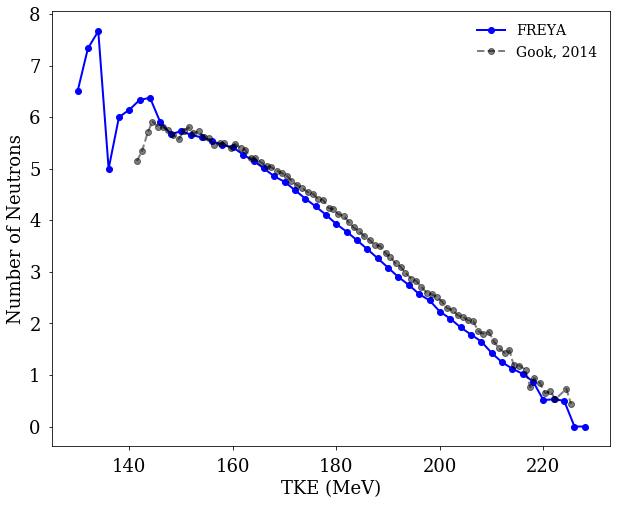

In [29]:
fig = figure(figsize(10,8))

plt.plot(freya_output['n_TKE'][:,0],freya_output['n_TKE'][:,1],'bo-',label="FREYA")

utils.plotExperimentalData (experiments,'nubarTKE')

plt.xlabel("TKE (MeV)")
plt.ylabel("Number of Neutrons")
lg = plt.legend(numpoints=1,fontsize=14)
lg.draw_frame(False)

plt.show()
fig.savefig(OUTPUTDIR+"nu_TKE.pdf")

### Neutron-Neutron Correlation

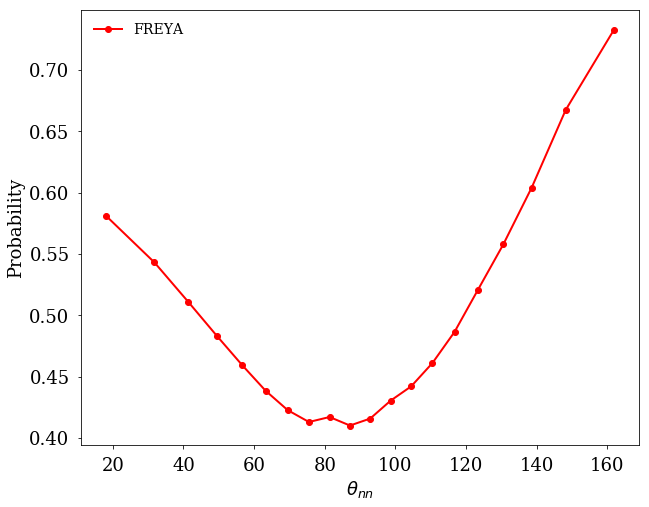

In [30]:
# EXERCISE: plot n-n angular distribution of any two neutrons out. Compare calculations with experiments

fig = figure(figsize(10,8))
plt.subplot(1,1,1,xlabel=r"$\theta_{nn}$",ylabel="Probability")

# plt.plot((freya_output['n_angular'][:,0]),freya_output['n_angular'][:,1],'bo-',label="FREYA")
plt.plot(np.arccos(freya_output['n_angular'][:,0])*180.0/np.pi,freya_output['n_angular'][:,1],'ro-',label="FREYA")

lg = plt.legend(numpoints=1,fontsize=14)
lg.draw_frame(False)
plt.show()

fig.savefig(OUTPUTDIR+"n_angular.pdf")


## Prompt Fission Photons

Here the FREYA results are compared for photon emission.  The results are also compared with data where possible.

First results for the neutron multiplicity distribution are shown, both on a linear and a log scale.  The calculations are compared to the recent measurement by Oberstedt et al.  These results depend significantly on the minimum photon energy detection threshold and the time window of the measurement. 

Finally the prompt photon photon energy and energy per photon are shown as a function of fragment mass.

### Photon Multiplicity Distribution

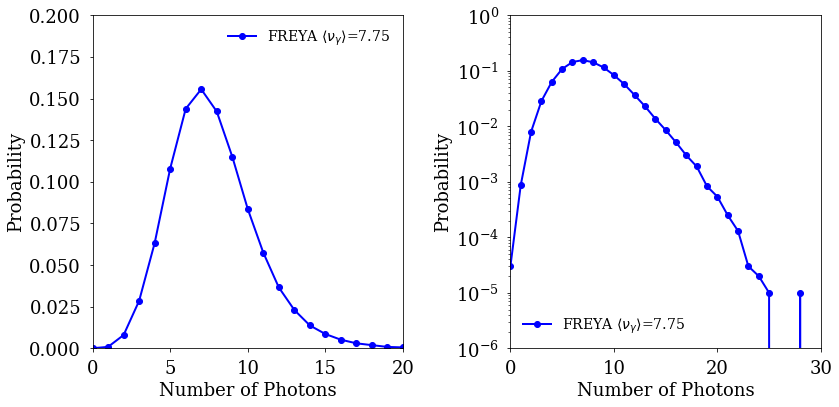

In [31]:
# EXERCISE: Plot photon multiplicity distribution in both lin- and log-scale
fig = figure(figsize(12,6))

#-- y-scale: linear
plt.subplot(1,2,1)
plt.plot(freya_output['m_mult'][:,0],freya_output['m_mult'][:,1],'bo-',label=r"FREYA $\langle \nu_\gamma \rangle$={0:.2f}".format(mean(freya_output['light_gammas'])+mean(freya_output['heavy_gammas'])))
#utils.plotExperimentalData (experiments,'Pnu')
plt.xlim(0,20)
plt.ylim(0.0,0.2)
plt.xlabel("Number of Photons")
plt.ylabel("Probability")
lg = plt.legend(numpoints=1,fontsize=14)
lg.draw_frame(False)

#-- y-scale: log
plt.subplot(1,2,2)
plt.plot(freya_output['m_mult'][:,0],freya_output['m_mult'][:,1],'bo-',label=r"FREYA $\langle \nu_\gamma \rangle$={0:.2f}".format(mean(freya_output['light_gammas'])+mean(freya_output['heavy_gammas'])))
#utils.plotExperimentalData (experiments,'Pnu')
plt.xlim(0,30)
plt.ylim(1e-6,1)
plt.xlabel("Number of Photons")
plt.ylabel("Probability")
plt.yscale('log')
lg = plt.legend(loc=3,numpoints=1,fontsize=14)
lg.draw_frame(False)


plt.tight_layout()
plt.show()
fig.savefig(OUTPUTDIR+"Pnug.pdf")

### Total Photon Energy and Multiplicity vs. Fragment Mass

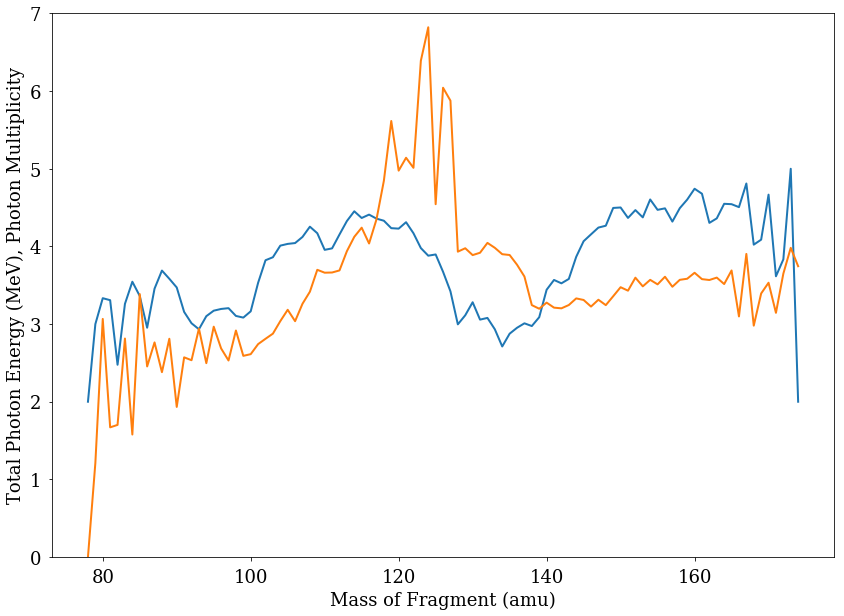

In [32]:
# EXERCISE: Plot total photon energy and photon multiplicity vs. fission fragment mass
fig = figure(figsize(14,10))

plt.subplot(1,1,1,xlabel="Mass of Fragment (amu)",ylabel="Total Photon Energy (MeV), Photon Multiplicity")
plt.plot(freya_output['m_Af'][:,0],freya_output['m_Af'][:,1])
plt.plot(freya_output['total_photon_energy'][:,0],freya_output['total_photon_energy'][:,1])

plt.ylim(0,7)

#lg.draw_frame(False)

plt.show()

fig.savefig(OUTPUTDIR+"nug_totgEn_A.pdf")

### Energy Per Photon

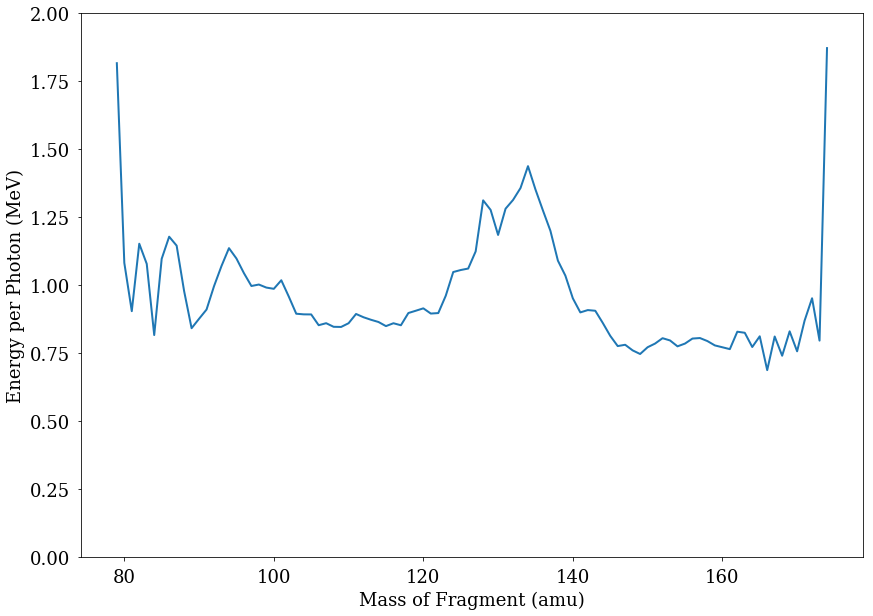

In [33]:
# EXERCISE: Plot energy per photon vs. mass. How do you explain this result?
fig = figure(figsize(14,10))

plt.subplot(1,1,1,xlabel="Mass of Fragment (amu)",ylabel="Energy per Photon (MeV)")
plt.plot(freya_output['energy_per_photon'][:,0],freya_output['energy_per_photon'][:,1])

plt.ylim(0,2)

#lg.draw_frame(False)

plt.show()

fig.savefig(OUTPUTDIR+"epsgamma_A.pdf")

## FREYA Comparisons

FREYA contains a number of adjustable parameters that control various physics aspects.  These parameters, for the most part, affect only one or two observables, as will be shown in this section.  

----------------------------------------

* $d{\rm TKE}$: an overall shift of $\overline{\rm TKE}$ relative to the input TKE($A$), used to adjust the average neutron multiplicity $\overline{\nu}$

* $e_0$: the overall scale of the Fermi-gas level density parameters

* $x$: the advantage in excitation energy given to the light fragment. It is currently single valued but could be made mass dependent.

* $c_S$: the ratio of the "spin temperature" to the "scission temperature".

* $c$: the relative statistical fluctuation in the fragment excitations.

----------------------------------------


So far, none of the FREYA parameters are assumed to depend on fragment mass.  The $d$TKE is adjusted as a function of $E_{\rm inc}$  to match $\overline \nu(E_{\rm inc})$.  As described shortly, the prescription for the calculation of the level density parameter is energy dependent even though $e_0$ itself is not.  There is currently insufficient information available to assume any energy dependence of $x$, $c_S$ or $c$.

The emission of photons in FREYA is governed by $c_S$.  There are two additional settings in FREYA that influence the photon results:

----------------------------------------


* $g_{\rm min}$: the minimum \gray~energy measurable by a given detector;

* $t_{\rm max}$: the maximum half-life of a level during the photon decay process (which stops when it reaches a level having a half-life exceeding $t_{\rm max}$).

----------------------------------------

The quantities $g_{\rm min}$ and $t_{\rm max}$ are detector dependent.  The parameter $t_{\rm max}$ arises because the codes employ the low energy photon transitions tabulated in the RIPL-3 compilation.  The low energy photons transition between levels with specific energies.  The time $t_{\rm max}$ is related to the half-life of the transitions:  if it is long, on the order of microseconds, the photon will not be detected as prompt.

We are going to look at how changing some of these parameters change specific observables.  Several of the parameters affect only one specific observable.  The additional data files we read in before will be used to show some of the sensitivities of the results to the parameters.  We change one parameter up and down while keeping all the others fixed.  Please note that the variation of the parameters is not based on parameter uncertainties but rather for illustrative purposes.  Also, be aware that changing one parameter would actually result in a poorer overall fit.

We start with changing $x$ around the default value and show its effect on $\nu(A)$ and the two-neutron correlations, two observables that are particularly sensitive to $x$.  We next look at the effect of changing $c$ on the neutron multiplicity distribution.  Next we change the default value of $c_S$ on the photon multiplicity distribution.  Finally, we show how changing $e_0$ changes the prompt fission neutron spectrum.  (Actually the spectrum is sensitive to all parameters.)

To show that some observables are insensitive to some of the parameters, students will plot the neutron multiplcity distribution $P(\nu)$ for the different values of $x$ and $c_S$; the neutron multiplicity as a function of $A$ for the three values of $x$; and the prompt fission neutron spectrum for the three values of $x$, $c$ and $c_S$.

### Study the sensitivity of FREYA results to changes in model input parameters

In [35]:
# Load a different FREYA output file
freya_events2, default_initial_line = freya_utils.freya_read("data/histories-Cf252sf-FREYA_xHi.dat")
freya_output2, ranges_x = freya_utils.freya_parse(freya_events2, NEVENTSREAD, default_initial_line, 1.0)

Importing Events...
1000000 events imported.
Time: 6.686191082000732 sec
Parsing events...
Time: 0.0008950233459472656 sec
All events parsed.
Time: 24.41626811027527 sec


### Effects of $x$ on neutron multiplicity vs. A

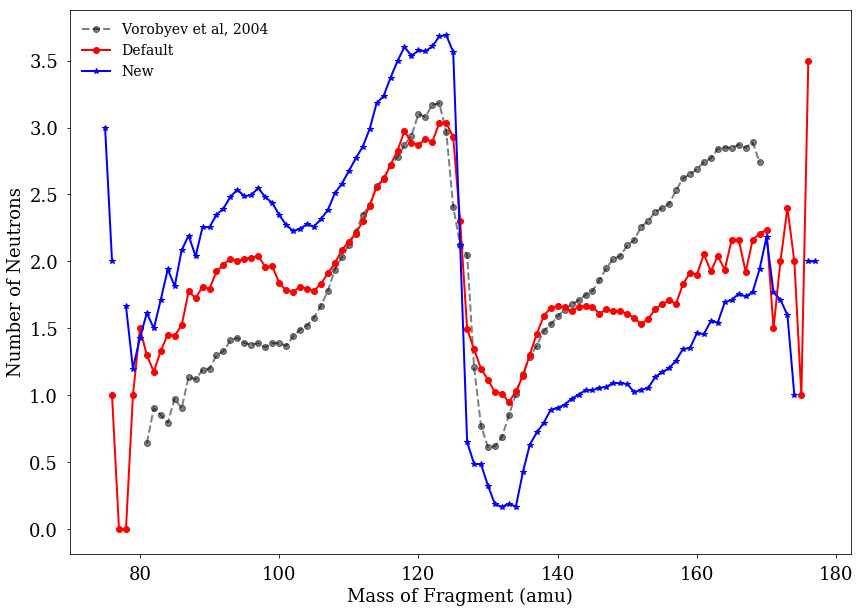

In [36]:
fig = figure(figsize(14,10))

plt.subplot(1,1,1,xlabel="Mass of Fragment (amu)",ylabel="Number of Neutrons")

utils.plotExperimentalData (experiments,'nubarA')

plt.plot(freya_output['n_Af'][:,0],freya_output['n_Af'][:,1],'ro-',label="Default")
plt.plot(freya_output2['n_Af'][:,0],freya_output2['n_Af'][:,1],'b*-',label="New")

lg = plt.legend(numpoints=1,fontsize=14)
lg.draw_frame(False)

plt.show()

fig.savefig(OUTPUTDIR+"x_nu_A.pdf")

### Effects of $x$ on 2-neutron correlation

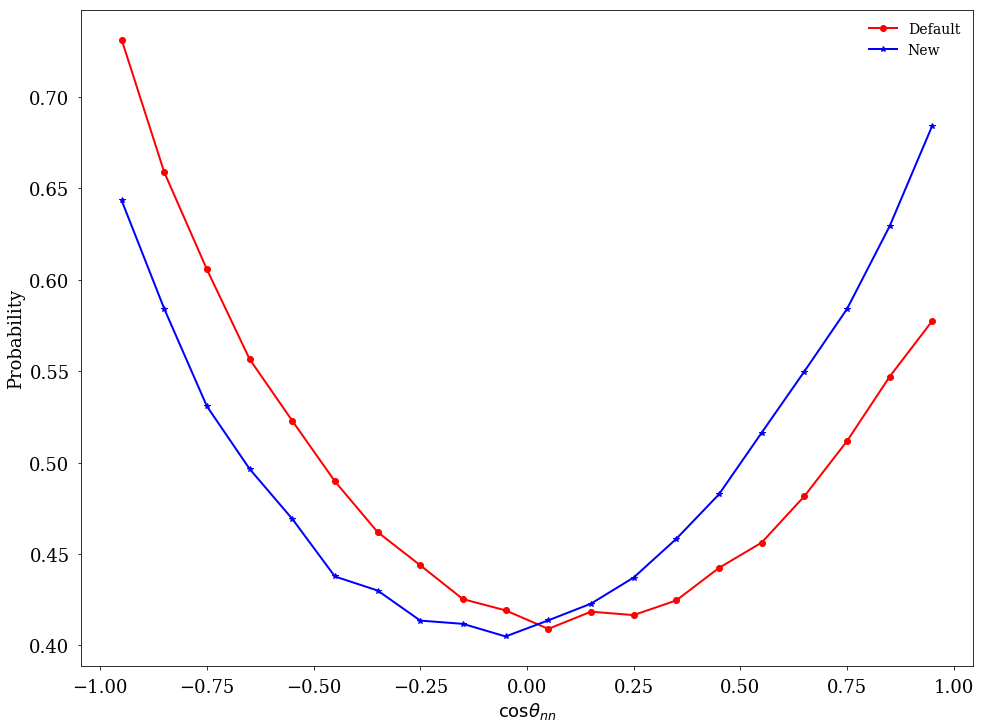

In [37]:
fig = figure(figsize(14,30))

plt.subplot(3,1,1,xlabel=r"$\cos \theta_{nn}$",ylabel="Probability")

plt.plot(freya_output['n_angular'][:,0],freya_output['n_angular'][:,1],'ro-',label="Default")
plt.plot(freya_output2['n_angular'][:,0],freya_output2['n_angular'][:,1],'b*-',label="New")

lg = plt.legend(numpoints=1,fontsize=14)
lg.draw_frame(False)

plt.tight_layout()
plt.show()

fig.savefig(OUTPUTDIR+"x_angular.pdf")

### Effects of $c$ on neutron multiplicity distribution

In [38]:
# Load a different FREYA output file
freya_eventsc, default_initial_line = freya_utils.freya_read("data/histories-Cf252sf-FREYA_cHi.dat")
freya_outputc, ranges_x = freya_utils.freya_parse(freya_eventsc, NEVENTSREAD, default_initial_line, 1.0)

Importing Events...
1000000 events imported.
Time: 34.759519815444946 sec
Parsing events...
Time: 0.0009129047393798828 sec
All events parsed.
Time: 14.009291887283325 sec


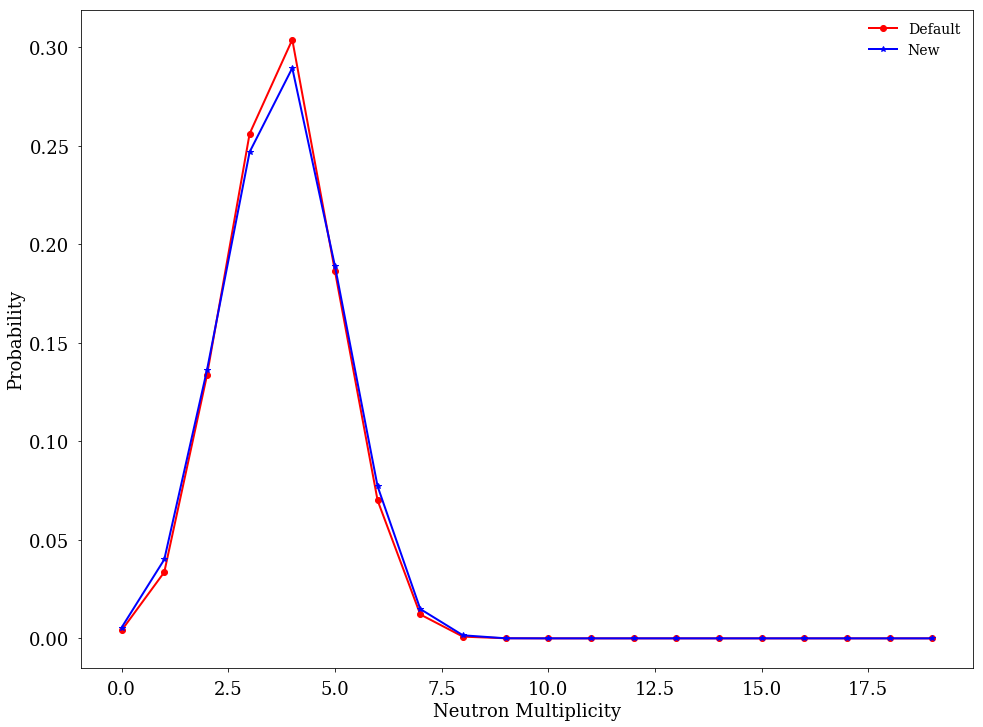

In [34]:
fig = figure(figsize(14,30))

plt.subplot(3,1,1,xlabel="Neutron Multiplicity",ylabel="Probability")

plt.plot(freya_output['n_mult'][:,0],freya_output['n_mult'][:,1],'ro-',label="Default")
plt.plot(freya_outputc['n_mult'][:,0],freya_outputc['n_mult'][:,1],'b*-',label="New")

lg = plt.legend(numpoints=1,fontsize=14)
lg.draw_frame(False)

plt.tight_layout()
plt.show()

fig.savefig(OUTPUTDIR+"c_n_mult.pdf")

### Effects of $c_S$ on Photon Multiplicity Distribution

In [35]:
# Load a different FREYA output file
freya_eventscs, default_initial_line = freya_utils.freya_read("data/histories-Cf252sf-FREYA_cSHi.dat")
freya_outputcs, ranges_x = freya_utils.freya_parse(freya_eventscs, NEVENTSREAD, default_initial_line, 1.0)

Importing Events...
1000000 events imported.
Time: 45.14441180229187 sec
Parsing events...
Time: 0.0029277801513671875 sec
All events parsed.
Time: 8.586180925369263 sec


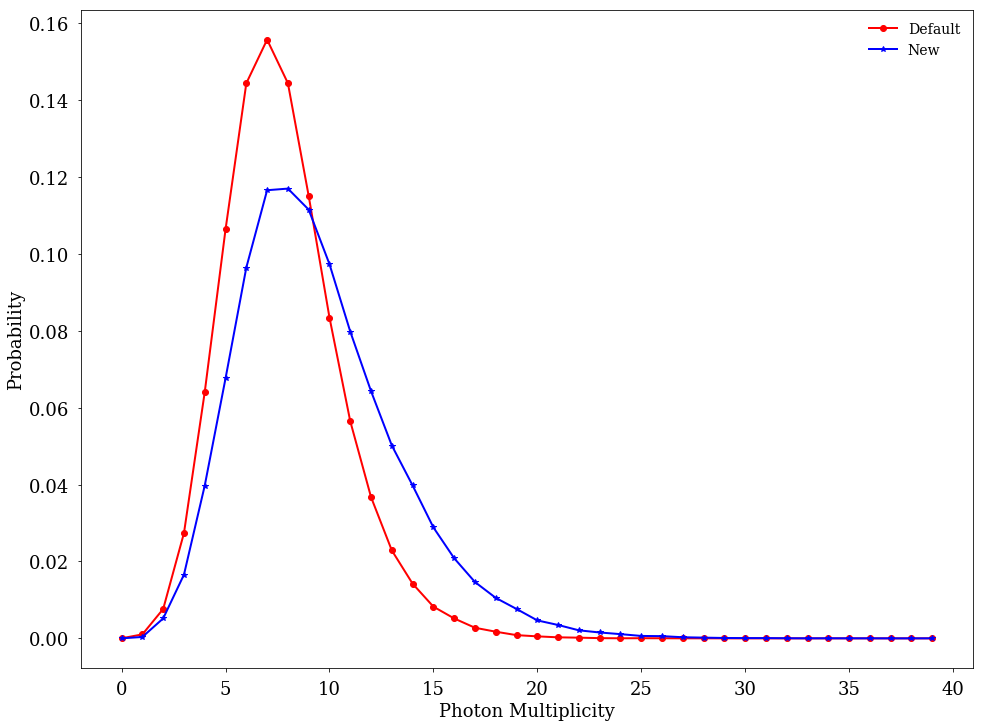

In [36]:
fig = figure(figsize(14,30))

plt.subplot(3,1,1,xlabel="Photon Multiplicity",ylabel="Probability")

plt.plot(freya_output['m_mult'][:,0],freya_output['m_mult'][:,1],'ro-',label="Default")
plt.plot(freya_outputcs['m_mult'][:,0],freya_outputcs['m_mult'][:,1],'b*-',label="New")

lg = plt.legend(numpoints=1,fontsize=14)
lg.draw_frame(False)

plt.tight_layout()
plt.show()

fig.savefig(OUTPUTDIR+"cS_m_mult.pdf")

### Effects of $e_0$ on prompt fission neutron spectrum

In [37]:
# Load a different FREYA output file
freya_eventse0, default_initial_line = freya_utils.freya_read("data/histories-Cf252sf-FREYA_e0Hi.dat")
freya_outpute0, ranges_x = freya_utils.freya_parse(freya_eventse0, NEVENTSREAD, default_initial_line, 1.0)

Importing Events...
1000000 events imported.
Time: 41.83002781867981 sec
Parsing events...
Time: 0.0012531280517578125 sec
All events parsed.
Time: 11.968655109405518 sec


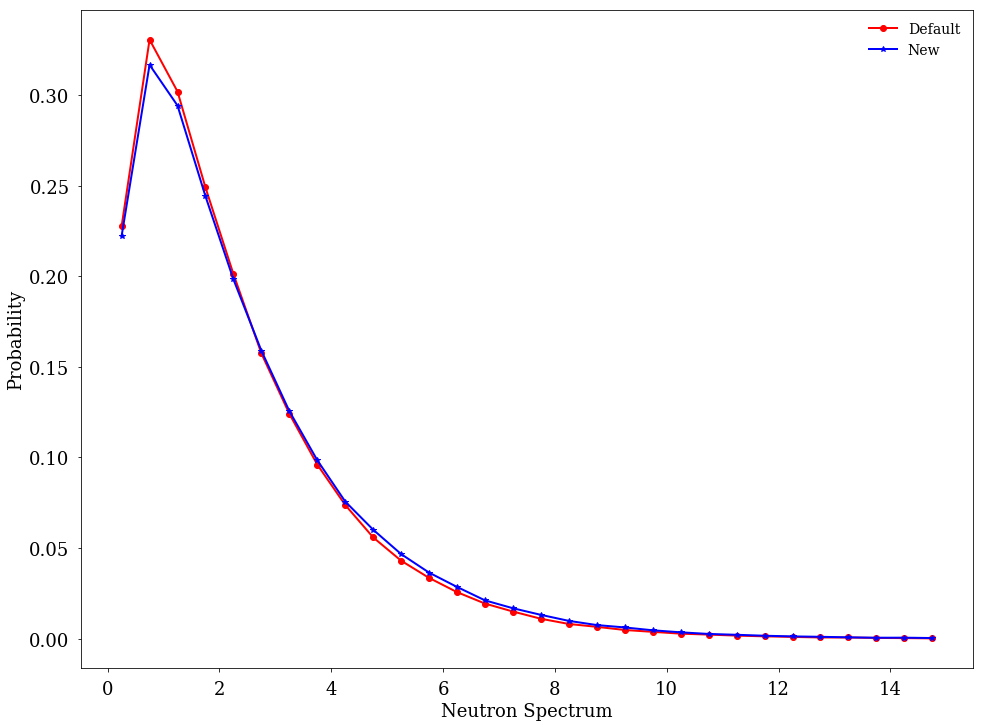

In [38]:
fig = figure(figsize(14,30))

plt.subplot(3,1,1,xlabel="Neutron Spectrum",ylabel="Probability")

plt.plot(freya_output['n_spectrum'][:,0],freya_output['n_spectrum'][:,1],'ro-',label="Default")
plt.plot(freya_outpute0['n_spectrum'][:,0],freya_outpute0['n_spectrum'][:,1],'b*-',label="New")

lg = plt.legend(numpoints=1,fontsize=14)
lg.draw_frame(False)

plt.tight_layout()
plt.show()

fig.savefig(OUTPUTDIR+"e0_n_spec.pdf")